# Mathematical Underpinnings - Lab 7


In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

# np.random.seed(123)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))


In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [6]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [7]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.1474884662230087

### c)


In [10]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [11]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [13]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 2s 36ms/step - loss: 0.0094 - val_loss: 0.0030
Epoch 2/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0278 - val_loss: -0.0219
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0442 - val_loss: -0.0341
Epoch 4/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0525 - val_loss: -0.0409
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: -0.0576 - val_loss: -0.0455
Epoch 6/100
15/15 [==============================] - 0s 11ms/step - loss: -0.0611 - val_loss: -0.0489
Epoch 7/100
15/15 [==============================] - 0s 15ms/step - loss: -0.0636 - val_loss: -0.0518
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: -0.0658 - val_loss: -0.0544
Epoch 9/100
15/15 [==============================] - 0s 10ms/step - loss: -0.0677 - val_loss: -0.0569
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: -0.0696 - va

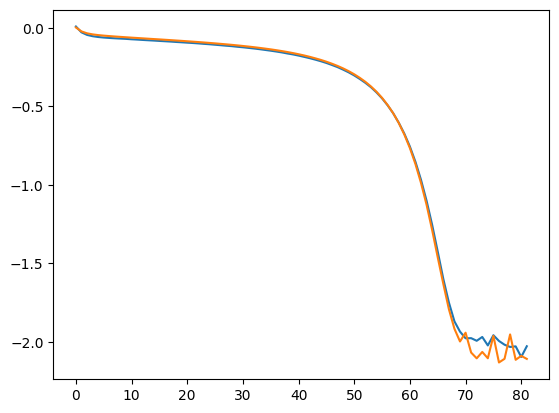

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [15]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 2s 3ms/step


In [17]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

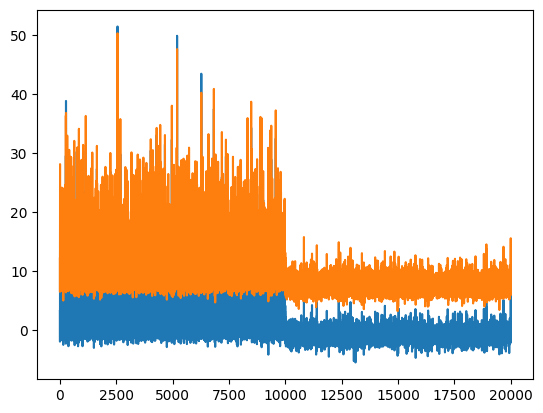

In [18]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

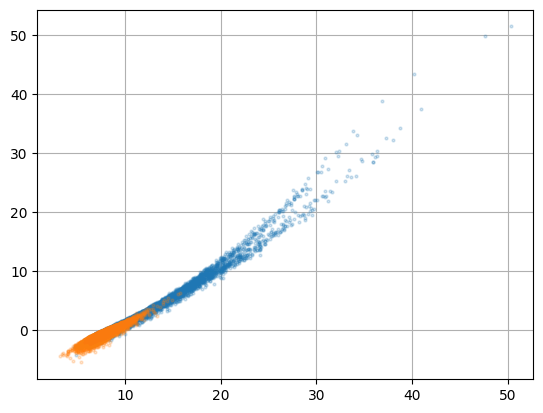

In [19]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

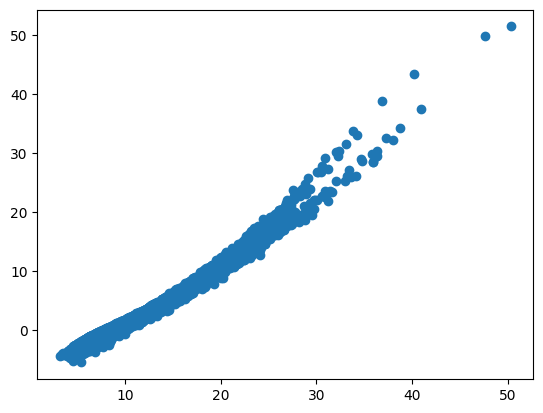

In [20]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [21]:
DV_fun(y, t_x_pred)

1.9157678892641652

In [22]:
DV_fun(y, t_x_opt)

2.1474884662230087

In [23]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [24]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 [==============================] - 2s 2ms/step


In [25]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [26]:
DV_fun(y_new, t_x_pred)

2.221327937613065

In [27]:
DV_fun(y_new, t_x_opt)

2.3589896505232546

### f)

In [30]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(
        tf.math.exp(tf.subtract(T_x, tf.convert_to_tensor(1.0))),
        tf.subtract(tf.convert_to_tensor(1.0), y_true))
    )/n2
    return -(first_term - second_term)

In [29]:
def NWJ_fun(y, t):
    return np.mean(t[y == 1]) - np.mean(np.exp(t[y == 0] - 1))

In [31]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [33]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 29ms/step - loss: -0.0059 - val_loss: -0.0349
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: -0.0436 - val_loss: -0.0587
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: -0.0611 - val_loss: -0.0684
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: -0.0696 - val_loss: -0.0744
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: -0.0736 - val_loss: -0.0779
Epoch 6/100
15/15 [==============================] - 0s 11ms/step - loss: -0.0767 - val_loss: -0.0802
Epoch 7/100
15/15 [==============================] - 0s 11ms/step - loss: -0.0788 - val_loss: -0.0812
Epoch 8/100
15/15 [==============================] - 0s 16ms/step - loss: -0.0803 - val_loss: -0.0832
Epoch 9/100
15/15 [==============================] - 0s 13ms/step - loss: -0.0817 - val_loss: -0.0847
Epoch 10/100
15/15 [==============================] - 0s 11ms/step - loss: -0.0833

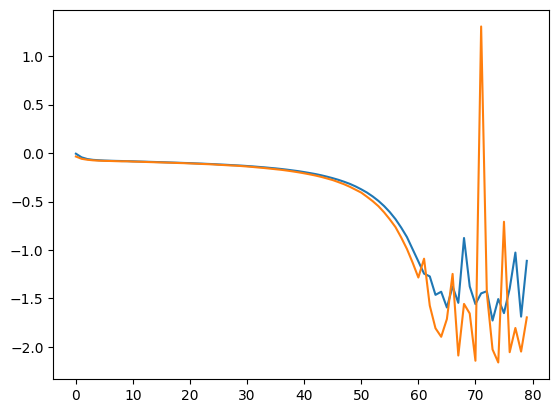

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [35]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 2s 3ms/step


In [36]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2) #+ 1

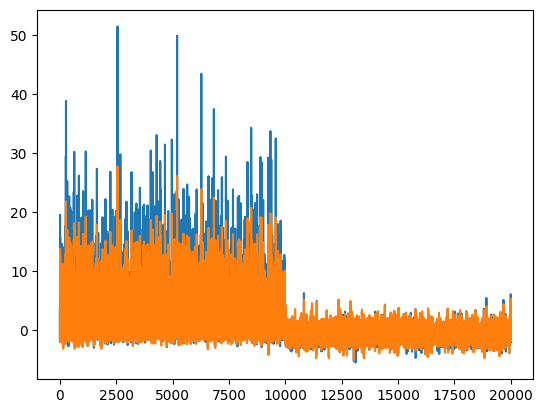

In [37]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

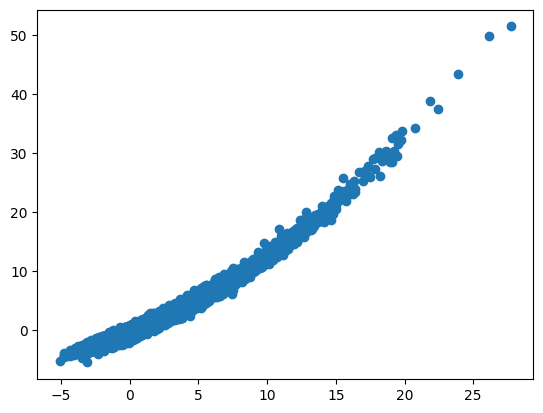

In [38]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [39]:
NWJ_fun(y, t_x_pred)

1.5673196

In [40]:
NWJ_fun(y, t_x_opt)

1.765466115267248

In [41]:
t_x_pred = model.predict(x_new)[:, 0]

625/625 [==============================] - 2s 3ms/step


In [45]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [43]:
NWJ_fun(y_new, t_x_pred)

1.6055425

In [46]:
NWJ_fun(y_new, t_x_opt)

1.882065033920334